In [ ]:
"""DMFT and RNN Simulation for the probability distribution of X """
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import norm
import matplotlib
import os

matplotlib.rcParams['font.sans-serif'] = ['Times New Roman']
matplotlib.rcParams['font.size'] = 23

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

delta_t = 0.1
step_t = 1000
Nd = 5000
Ns = 5000
step_c = 50
n = 50
T = step_t * delta_t
g_list = [ 1.1, 1.3 , 1.5]
Color_list = ['skyblue', 'orange', 'limegreen', 'red']

save_dir = "./"
summary_file = os.path.join(save_dir, "dmft_summary.csv")
if not os.path.exists(summary_file):
    with open(summary_file, "w") as fsum:
        fsum.write("g,var_D\n")

plt.figure(figsize=(8, 6))
for idx, g in enumerate(g_list):
    print(f"\nProcessing g = {g:.2f}")
    '''DMFT'''
    eta = torch.zeros((Nd, step_t, step_c + 1), device=device)
    x_0 = torch.randn(Nd, device=device)
    mean = torch.zeros(step_t)
    convariance = torch.eye(step_t)
    eta[:, :, 0] = torch.tensor(
        np.random.multivariate_normal(mean.numpy(), convariance.numpy(), size=Nd),
        dtype=torch.float32).to(device)
    X = torch.zeros((Nd, step_t + 1), device=device)
    D = torch.zeros((step_t, step_c), device=device)
    for i in tqdm(range(step_c), desc=f"DMFT g={g}"):
        for t in range(1, step_t):
            dx_dt = -delta_t * X[:, t] + delta_t * eta[:, t, i]
            X[:, t + 1] = X[:, t] + dx_dt
            D[t, i] = torch.mean(X[:, t]**2)
        phi_X = torch.tanh(X[:, :-1])
        Ctt_d = phi_X.T @ phi_X / phi_X.shape[0]
        Dtt_d = X.T@ X / X.shape[0]
        convariance = (g**2) * Ctt_d.detach().cpu().numpy()
        eta[:, :, i + 1] = torch.tensor(
            np.random.multivariate_normal(mean.numpy(), convariance, size=Nd),
            dtype=torch.float32).to(device)
    var_D = Dtt_d[-1, -1].item()
    print(f"DMFT var_D = {var_D:.6f}")

    '''RNN Simulation'''
    X_s = torch.zeros((n, Ns, step_t + 1), device=device)
    phi_X_s = torch.zeros((n, Ns, step_t + 1), device=device)
    D_s = torch.zeros((n, step_t), device=device)
    for i in tqdm(range(n), desc=f"Simulation g={g}"):
        X_s[i, :, 0] = torch.randn(Ns, device=device)
        J = torch.randn((Ns, Ns), device=device) * (g / np.sqrt(Ns))
        for t in range(step_t):
            phi = torch.tanh(X_s[i, :, t])
            X_s[i, :, t + 1] = (1 - delta_t) * X_s[i, :, t] + delta_t * torch.matmul(J, phi)
            D_s[i, t] = torch.mean(X_s[i, :, t] ** 2)
    X_s_recorded = X_s[:, :, -1].reshape(-1).cpu().numpy()
    x_theory = np.linspace(-5 * np.sqrt(var_D), 5 * np.sqrt(var_D), 500)
    P_theory = norm.pdf(x_theory, loc=0, scale=np.sqrt(var_D))

    df_sample = pd.DataFrame(X_s_recorded, columns=[f"x_sample_g{g:.2f}"])
    df_sample.to_csv(os.path.join(save_dir, f"rnn_samples_g{g:.2f}.csv"), index=False)

    df_theory = pd.DataFrame({"x": x_theory, "P_theory": P_theory})
    df_theory.to_csv(os.path.join(save_dir, f"dmft_theory_g{g:.2f}.csv"), index=False)

    with open(summary_file, "a") as fsum:
        fsum.write(f"{g:.2f},{var_D:.8f}\n")
    plt.hist(X_s_recorded, bins=60, density=True, alpha=0.4,
             edgecolor=Color_list[idx], linewidth=0.8, facecolor=Color_list[idx],
             label=f'RNN $g={g}$')
    plt.plot(x_theory, P_theory, lw=2, color=Color_list[idx],
             linestyle='--', label=f'DMFT $g={g}$')
    
plt.xlabel('$x$')
plt.ylabel('Probability Density')
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "distributions_multi_g.pdf"), dpi=300)
plt.show()


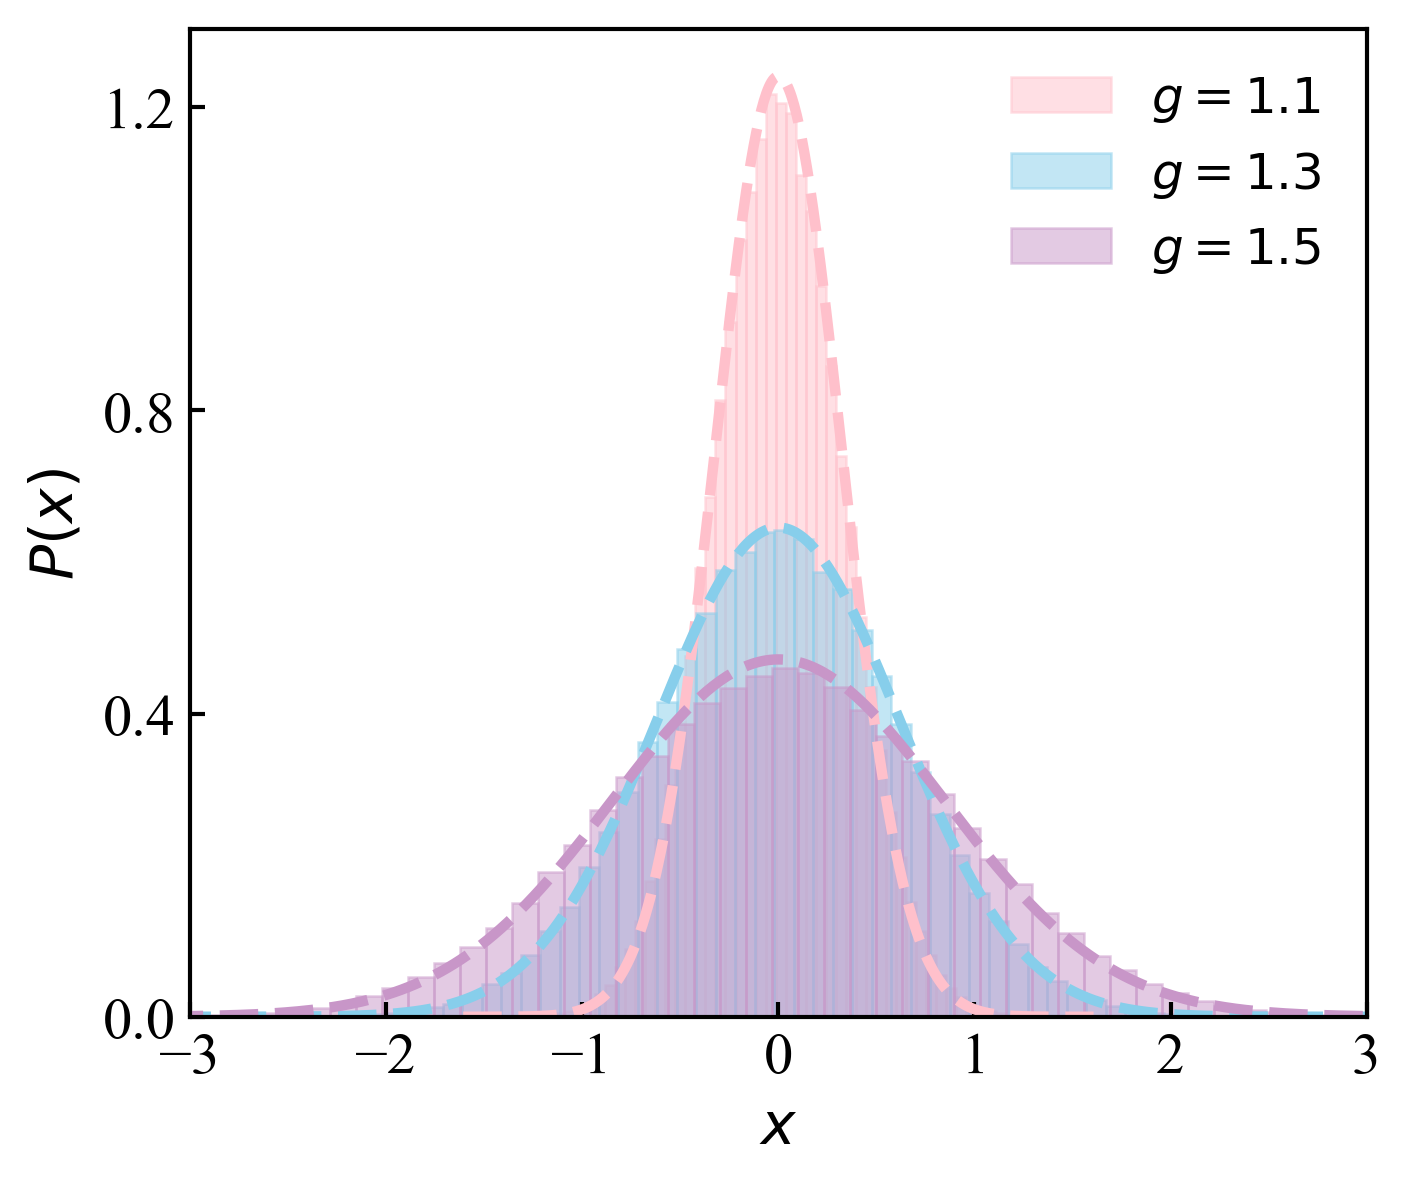

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib

matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.size'] = 8  
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['legend.frameon'] = False

g_list = [ 1.1, 1.3 , 1.5]
Color_list = ['pink','skyblue','#C896C8' ,'#B8A8CF', 'orange']
save_dir = "./"

fig, ax = plt.subplots(figsize=(4.5, 3.8), dpi=300)
for idx, g in enumerate(g_list):
    sample_file = os.path.join(save_dir, f"rnn_samples_g{g:.2f}.csv")
    df_sample = pd.read_csv(sample_file)
    X_sample = df_sample.iloc[:, 0].values  
    theory_file = os.path.join(save_dir, f"dmft_theory_g{g:.2f}.csv")
    df_theory = pd.read_csv(theory_file)
    x_theory = df_theory["x"].values
    P_theory = df_theory["P_theory"].values
    ax.hist(X_sample, bins=60, density=True, alpha=0.5, edgecolor=Color_list[idx], linewidth=0.6, facecolor=Color_list[idx], label=rf'$g={g:.1f}$')
    ax.plot(x_theory, P_theory, linestyle='--', lw=2.5, color=Color_list[idx])

ticks_vals = [0.0, 0.4,  0.8,1.2]
ax.set_yticks(ticks_vals)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$P(x)$", fontsize=14)
ax.legend(fontsize=12, loc='upper right', handlelength=2)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(-3, 3)
plt.tight_layout(pad=0.2)
plt.savefig("plot_from_csv_result.pdf", format='pdf')
plt.show()

